In [1]:
import numpy as np
from umap import UMAP
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
import os
from sklearn.decomposition import PCA
import scipy

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [3]:
from data.pdb_utils import VOCAB

In [4]:
UMAP_n_neighbors_list = [5, 20, 100]
UMAP_min_dist_list = [0.1, 0.0, 0.5]

# Graph Level Embeddings

In [5]:
embedding_dir = "/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/case_studies/visualise_nodes/PLA30/"

## Finetuned

In [6]:
with open(f"{embedding_dir}/data_finetuned/graph_embeddings.npy", "rb") as f:
    embeddings = np.load(f)

if os.path.exists(f"{embedding_dir}/data_finetuned/graph_embedding_2d.npy"):
    with open(f"{embedding_dir}/data_finetuned/graph_embedding_2d.npy", "rb") as f:
        proj_2d_graph = np.load(f)
else:
    n_neighbors = 20
    min_dist = 0.1
    umap_2d = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        init="random",
        random_state=0,
    )
    proj_2d_graph = umap_2d.fit_transform(embeddings)
    with open(f"{embedding_dir}/data_finetuned/graph_embedding_2d.npy", "wb") as f:
        np.save(f, proj_2d_graph)

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


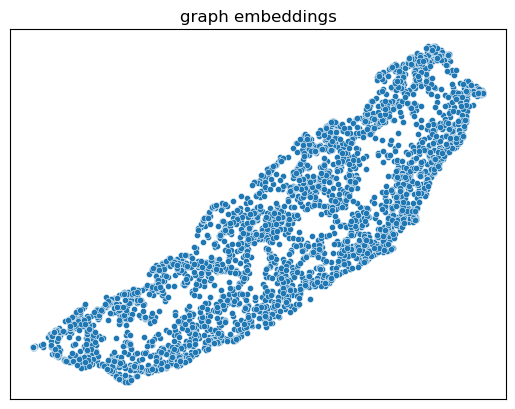

In [7]:
df = pd.DataFrame(proj_2d_graph, columns=["x", "y"])
ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    alpha=1,
    s=20,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.title("graph embeddings")
plt.show()

## Pretrained

In [8]:
with open(f"{embedding_dir}/data_pretrained/graph_embeddings.npy", "rb") as f:
    embeddings = np.load(f)

if os.path.exists(f"{embedding_dir}/data_pretrained/graph_embedding_2d.npy"):
    with open(f"{embedding_dir}/data_pretrained/graph_embedding_2d.npy", "rb") as f:
        proj_2d_graph_pretrained = np.load(f)
else:
    n_neighbors = 20
    min_dist = 0.1
    umap_2d = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        init="random",
        random_state=0,
    )
    proj_2d_graph_pretrained = umap_2d.fit_transform(embeddings)
    with open(f"{embedding_dir}/data_pretrained/graph_embedding_2d.npy", "wb") as f:
        np.save(f, proj_2d_graph_pretrained)

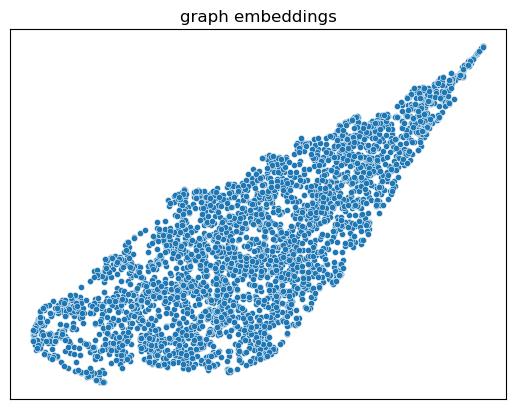

In [9]:
df = pd.DataFrame(proj_2d_graph_pretrained, columns=["x", "y"])
ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    alpha=1,
    s=20,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.title("graph embeddings")
plt.show()

## Both Finetuned and Pretrained

In [10]:
if os.path.exists(f"{embedding_dir}/data_finetuned/graph_embedding_2d.npy"):
    with open(f"{embedding_dir}/data_finetuned/graph_embedding_2d.npy", "rb") as f:
        proj_2d_graph_ft = np.load(f)
if os.path.exists(f"{embedding_dir}/data_pretrained/graph_embedding_2d.npy"):
    with open(f"{embedding_dir}/data_pretrained/graph_embedding_2d.npy", "rb") as f:
        proj_2d_graph_pt = np.load(f)

R, sca = scipy.linalg.orthogonal_procrustes(proj_2d_graph_ft, proj_2d_graph_pt)

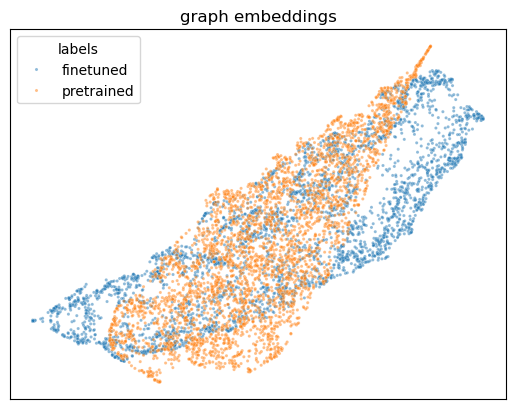

In [11]:
df1 = pd.DataFrame(np.matmul(proj_2d_graph_ft, R), columns=["x", "y"])
df1["labels"] = ["finetuned"] * len(df1)
df2 = pd.DataFrame(proj_2d_graph_pt, columns=["x", "y"])
df2["labels"] = ["pretrained"] * len(df2)
df = pd.concat([df1, df2])
ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="labels",
    alpha=0.5,
    s=5,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.title("graph embeddings")
plt.show()

# Average block level embeddings

## Finetuned

In [10]:
n_neighbors = 3
min_dist = 1

with open(f"{embedding_dir}/data_finetuned/block_id.npy", "rb") as f:
    block_id = np.load(f)

with open(f"{embedding_dir}/data_finetuned/block_embeddings.npy", "rb") as f:
    embeddings = np.load(f)

# Unique group IDs
unique_aa = np.unique(block_id)

# Initialize an empty list to store the mean of each group
group_means = []

# Iterate over each group and compute the mean
for group in unique_aa:
    if group < 37 and group > 3:
        group_mask = block_id == group
        group_rows = embeddings[group_mask]
        group_mean = np.mean(group_rows, axis=0)
        group_means.append(group_mean)

unique_aa = unique_aa[(unique_aa < 37) & (unique_aa > 3)]

# Convert list of group means to a numpy array if needed
group_means_array = np.array(group_means)

umap_2d = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    init="random",
    random_state=0,
)
proj_2d_aa = umap_2d.fit_transform(group_means_array)

FileNotFoundError: [Errno 2] No such file or directory: '/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/case_studies/visualise_nodes/BioLiP//data_finetuned/block_id.npy'

In [35]:
for i in unique_aa:
    print(i, VOCAB.idx_to_abrv(i))

4 GLY
5 ALA
6 VAL
7 LEU
8 ILE
9 PHE
10 TRP
11 TYR
12 ASP
13 HIS
14 ASN
15 GLU
16 LYS
17 GLN
18 MET
19 ARG
20 SER
21 THR
22 CYS
23 PRO


In [6]:
aa_type_color_dict = {
 'polar': '#1E90FF', 'sulfur': '#FFD700',     
 'hydrophobic': '#8B4513',
 'aromatic': '#800080',
 'positive': '#00FF00',   
 'negative': '#FF4500',
 "unknown": "#000000",
}

AA_TYPE = {
 'GLY': 'hydrophobic',
 'PRO': 'hydrophobic',
 'ALA': 'hydrophobic',
 'ILE': 'hydrophobic',
 'LEU': 'hydrophobic',
 'VAL': 'hydrophobic',
 'ASN': 'polar',
 'CYS': 'polar',
 'GLN': 'polar',
 'SER': 'polar',
 'THR': 'polar',
 'PHE': 'aromatic',
 'TYR': 'aromatic',
 'TRP': 'aromatic',
 'HIS': 'positive', # and polar, aromatic
 'ARG': 'positive',
 'LYS': 'positive',
 'ASP': 'negative',
 'GLU': 'negative',
 'MET': 'sulfur',
}

AA_IDX_COLOR = {
    4: '#87CEEB',  # Sky Blue
    5: '#32CD32',  # Lime Green
    6: '#FF7F50',  # Coral Pink
    7: '#E6E6FA',  # Lavender
    8: '#008080',  # Teal
    9: '#36454F',  # Charcoal Gray
    10: '#DAA520', # Goldenrod
    11: '#DDA0DD', # Plum
    12: '#007BA7', # Cerulean
    13: '#808000', # Olive Green
    14: '#CC5500', # Burnt Orange
    15: '#DC143C', # Crimson
    16: '#FF00FF', # Magenta
    17: '#4B0082', # Indigo
    18: '#F4C430', # Saffron
    19: '#6A5ACD', # Slate Blue
    20: '#98FF98', # Mint Green
    21: '#FFDAB9', # Peach
    22: '#9B111E', # Ruby Red
    23: '#C0C0C0', # Silver
}

### Principle Components

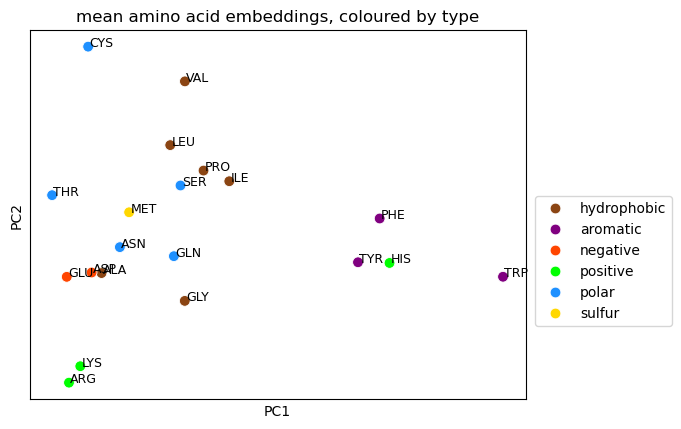

In [8]:
pca = PCA(n_components=2)
aa_pca = pca.fit_transform(group_means_array)
df = pd.DataFrame(aa_pca, columns=["x", "y"])
df["aa_index"] = unique_aa
df["aa_type"] = [AA_TYPE.get(VOCAB.idx_to_abrv(i), "unknown") for i in unique_aa]

ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="aa_type",
    alpha=1,
    s=60,
    palette=aa_type_color_dict,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()
for i in range(len(df['x'])):
    plt.text(df['x'][i] + 0.001,  # X position, with a slight offset to avoid overlapping the point
             df['y'][i],       # Y position
             VOCAB.idx_to_abrv(df['aa_index'][i]),  # Text label
             fontsize=9)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title("mean amino acid embeddings, coloured by type")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Pretrained

In [9]:
n_neighbors = 3
min_dist = 1

with open(f"{embedding_dir}/data_pretrained/block_id.npy", "rb") as f:
    block_id = np.load(f)

with open(f"{embedding_dir}/data_pretrained/block_embeddings.npy", "rb") as f:
    embeddings = np.load(f)

# Unique group IDs
unique_aa = np.unique(block_id)

# Initialize an empty list to store the mean of each group
group_means = []

# Iterate over each group and compute the mean
for group in unique_aa:
    if group < 37 and group > 3:
        group_mask = block_id == group
        group_rows = embeddings[group_mask]
        group_mean = np.mean(group_rows, axis=0)
        group_means.append(group_mean)

# Convert list of group means to a numpy array if needed
group_means_array = np.array(group_means)
unique_aa = unique_aa[(unique_aa < 37) & (unique_aa > 3)]

umap_2d = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    init="random",
    random_state=0,
)
proj_2d_aa = umap_2d.fit_transform(group_means_array)

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


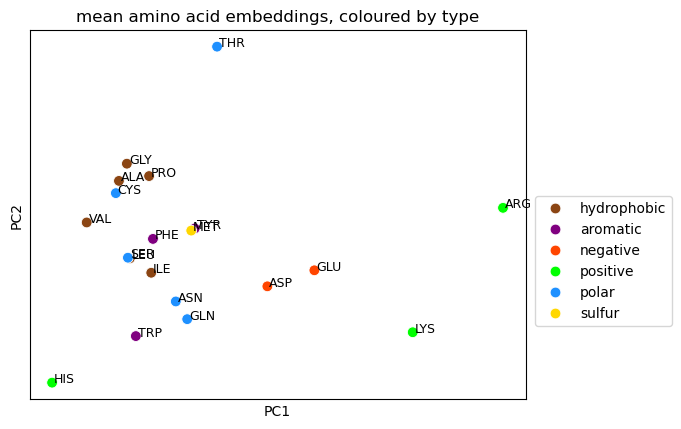

In [10]:
pca = PCA(n_components=2)
aa_pca = pca.fit_transform(group_means_array)
df = pd.DataFrame(aa_pca, columns=["x", "y"])
df["aa_index"] = unique_aa
df["aa_type"] = [AA_TYPE.get(VOCAB.idx_to_abrv(i), "unknown") for i in unique_aa]

ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="aa_type",
    alpha=1,
    s=60,
    palette=aa_type_color_dict,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()
for i in range(len(df['x'])):
    plt.text(df['x'][i] + 0.001,  # X position, with a slight offset to avoid overlapping the point
             df['y'][i],       # Y position
             VOCAB.idx_to_abrv(df['aa_index'][i]),  # Text label
             fontsize=9)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title("mean amino acid embeddings, coloured by type")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Block level embeddings

## Finetuned

In [25]:
n_neighbors = 5
min_dist = 0.0

with open(f"{embedding_dir}/data_finetuned/block_id.npy", "rb") as f:
    block_id = np.load(f)

with open(f"{embedding_dir}/data_finetuned/block_embeddings.npy", "rb") as f:
    embeddings = np.load(f)

embeddings = embeddings[(block_id < 37) & (block_id > 3)]
block_id = block_id[(block_id < 37) & (block_id > 3)]

umap_file = f"{embedding_dir}/data_finetuned/block_embedding_2d_neighbours_{n_neighbors}_dist_{min_dist}.npy"
if os.path.exists(umap_file):
    with open(umap_file, "rb") as f:
        proj_2d_aa = np.load(f)
else:
    umap_2d = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        init="random",
        random_state=0,
    )
    proj_2d_aa = umap_2d.fit_transform(embeddings)
    with open(umap_file, "wb") as f:
        np.save(f, proj_2d_aa)

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [26]:
np.unique(block_id)

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23])

In [27]:
color_dict = {
    4: '#C54672', 5: '#5F4B02', 6: '#85CC2D', 7: '#0B371A', 8: '#8E25B3',
    9: '#07B558', 10: '#82C860', 11: '#87D6A1', 12: '#A1692E', 13: '#164EDA',
    14: '#F136E1', 15: '#58C4F4', 16: '#9CA0A5', 17: '#F00256', 18: '#118CBD',
    19: '#57D19F', 20: '#FFB003', 21: '#9490CA', 22: '#F2374E', 23: '#AEE22E',
#     37: '#AFA287', 38: '#D0A2A5', 39: '#413744', 40: '#419E77', 46: '#0D797B',
#     47: '#5CFA32', 48: '#82FD69', 50: '#7198D3', 66: '#577A3D', 84: '#A79069'
}

In [28]:
# plot with plotly
traces = defaultdict(list)
for idx, label in enumerate(block_id):
    if label in color_dict:
        traces[label].append(proj_2d_aa[idx])
data = []
for label, coords in traces.items():
    coords = np.stack(coords)
    data.append(
        go.Scatter(
            x=coords[:, 0],
            y=coords[:, 1],
            mode="markers",
            text=str(label),
            name=str(label),
            marker=dict(size=5, opacity=0.5, color=color_dict[label]),
        )
    )
fig = go.Figure(data=data)
fig.update_layout(title="amino acid embeddings", showlegend=True, template="simple_white")
fig.write_html(f"amino_acid_embeddings.html")

In [38]:
VOCAB.idx_to_abrv(19)

'ARG'

In [40]:
VOCAB.abrv_to_idx('GLU')

15

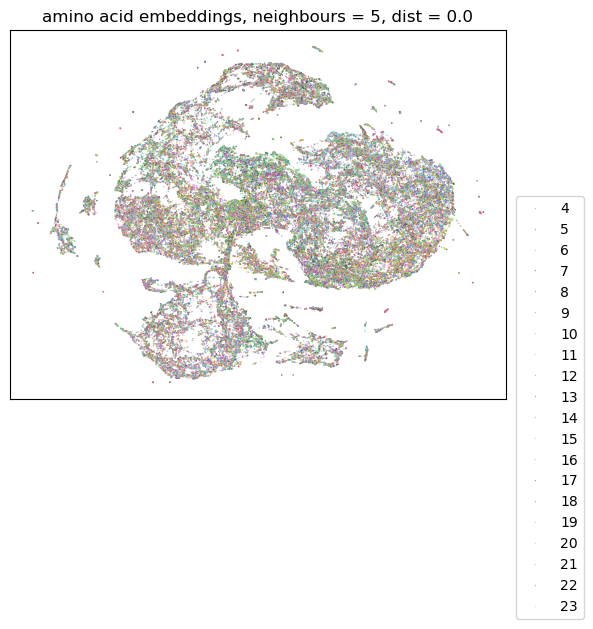

In [33]:
df = pd.DataFrame(proj_2d_aa, columns=["x", "y"])
df["labels"] = block_id
df = df[df["labels"].isin(color_dict.keys())]
# plt.savefig(f"{out_file_path}.png", format="png", dpi=1200)
# plt.close()
plot_df = df #[df["labels"] == 21]
ax = sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="labels",
    alpha=0.5,
    s=1,
    palette=color_dict,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title(f"amino acid embeddings, neighbours = {n_neighbors}, dist = {min_dist}")
plt.show()

## Pretrained

In [38]:
n_neighbors = 5
min_dist = 0.0

with open(f"{embedding_dir}/data_pretrained/block_id.npy", "rb") as f:
    block_id = np.load(f)

with open(f"{embedding_dir}/data_pretrained/block_embeddings.npy", "rb") as f:
    embeddings = np.load(f)

embeddings = embeddings[(block_id < 37) & (block_id > 3)]
block_id = block_id[(block_id < 37) & (block_id > 3)]

umap_file = f"{embedding_dir}/data_pretrained/block_embedding_2d_neighbours_{n_neighbors}_dist_{min_dist}.npy"
if os.path.exists(umap_file):
    with open(umap_file, "rb") as f:
        proj_2d_aa = np.load(f)
else:
    umap_2d = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        init="random",
        random_state=0,
    )
    proj_2d_aa = umap_2d.fit_transform(embeddings)
    with open(umap_file, "wb") as f:
        np.save(f, proj_2d_aa)

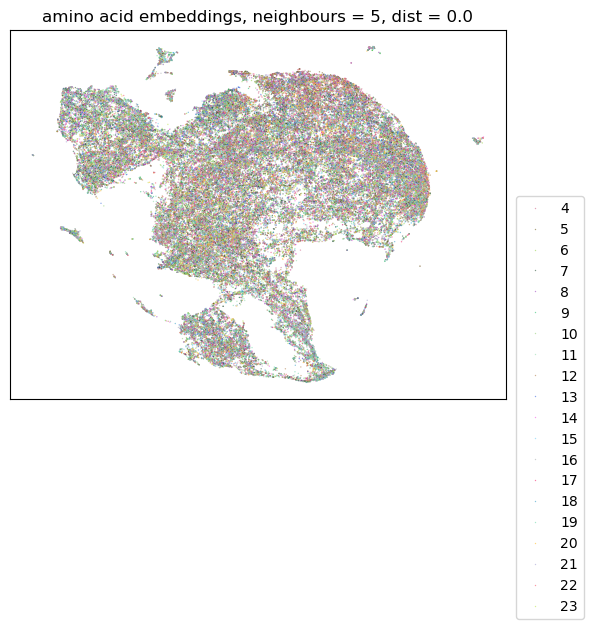

In [40]:
df = pd.DataFrame(proj_2d_aa, columns=["x", "y"])
df["labels"] = block_id
df = df[df["labels"].isin(color_dict.keys())]
# plt.savefig(f"{out_file_path}.png", format="png", dpi=1200)
# plt.close()
ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="labels",
    alpha=0.5,
    s=1,
    palette=color_dict,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title(f"amino acid embeddings, neighbours = {n_neighbors}, dist = {min_dist}")
plt.show()

# Atom level embeddings

In [20]:
element_type = {
    'C': 'Nonmetal',
    'N': 'Nonmetal',
    'O': 'Nonmetal',
    'P': 'Nonmetal',
    'S': 'Nonmetal',
    'F': 'Halogen',
    'Cl': 'Halogen',
    'Br': 'Halogen',
    'I': 'Halogen',
    'Na': 'Alkali metal',
    'K': 'Alkali metal',
    'Cs': 'Alkali metal',
    'Mg': 'Alkaline earth metal',
    'Ca': 'Alkaline earth metal',
    'Sr': 'Alkaline earth metal',
    'Mn': 'Transition metal',
    'Fe': 'Transition metal',
    'Co': 'Transition metal',
    'Ni': 'Transition metal',
    'Cu': 'Transition metal',
    'Zn': 'Transition metal',
    'Cd': 'Transition metal',
}

element_type_hex_code = {
    'Nonmetal': '#FFD700',  # Gold
    'Halogen': '#FF4500',   # OrangeRed
    'Alkali metal': '#8A2BE2',  # BlueViolet
    'Alkaline earth metal': '#00BFFF',  # DeepSkyBlue
    'Transition metal': '#20B2AA',  # LightSeaGreen
}

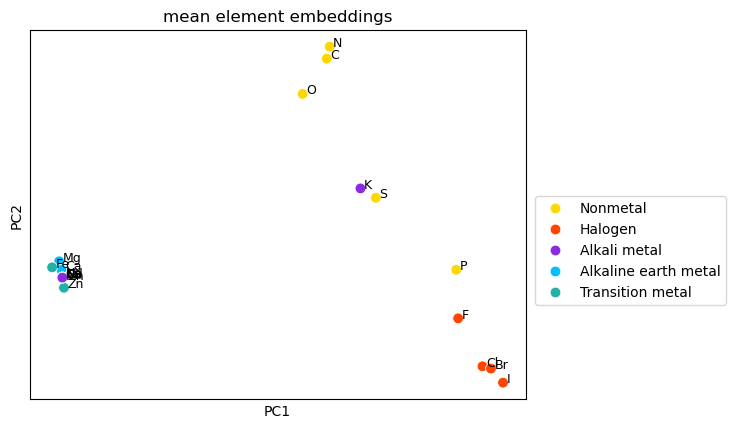

In [22]:
with open(f"{embedding_dir}/data_pretrained/atom_id.npy", "rb") as f:
    atom_id = np.load(f)
with open(f"{embedding_dir}/data_pretrained/atom_embeddings.npy", "rb") as f:
    atom_embeddings = np.load(f)

atom_embeddings = atom_embeddings[:, :atom_embeddings.shape[1]//2]

atom_embeddings = atom_embeddings[atom_id > 2]
atom_id = atom_id[atom_id > 2]

# Unique group IDs
unique_atoms = np.unique(atom_id)

# Initialize an empty list to store the mean of each group
group_means = []

# Iterate over each group and compute the mean
for group in unique_atoms:
    group_mask = atom_id == group
    group_rows = atom_embeddings[group_mask]
    group_mean = np.mean(group_rows, axis=0)
    group_means.append(group_mean)

# Convert list of group means to a numpy array if needed
group_means_array = np.array(group_means)

pca = PCA(n_components=2)
aa_pca = pca.fit_transform(group_means_array)
df = pd.DataFrame(aa_pca, columns=["x", "y"])
df["atom_index"] = unique_atoms
df["element"] = [VOCAB.idx_to_atom(i) for i in unique_atoms]
df["type"] = [element_type.get(VOCAB.idx_to_atom(i), "unknown") for i in unique_atoms]

ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="type",
    alpha=1,
    s=60,
    palette=element_type_hex_code,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
for i in range(len(df['x'])):
    plt.text(df['x'][i] + 0.01,  # X position, with a slight offset to avoid overlapping the point
             df['y'][i],       # Y position
             df["element"][i],  # Text label
             fontsize=9)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title("mean element embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

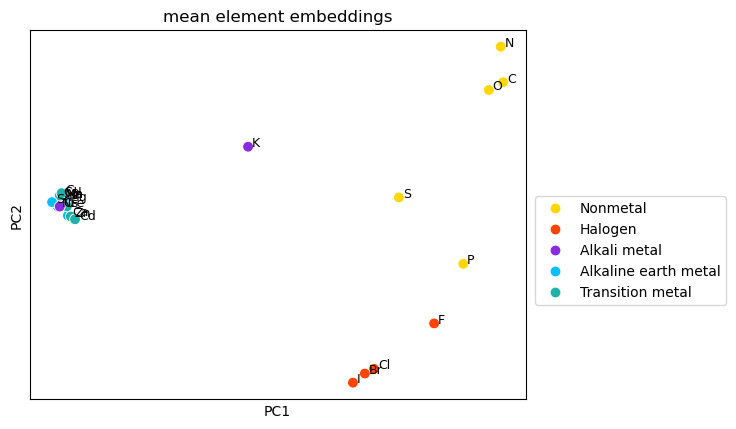

In [23]:
with open(f"{embedding_dir}/data_finetuned/atom_id.npy", "rb") as f:
    atom_id = np.load(f)
with open(f"{embedding_dir}/data_finetuned/atom_embeddings.npy", "rb") as f:
    atom_embeddings = np.load(f)

atom_embeddings = atom_embeddings[atom_id > 2]
atom_id = atom_id[atom_id > 2]
atom_embeddings = atom_embeddings[:, :atom_embeddings.shape[1]//2]


# Unique group IDs
unique_atoms = np.unique(atom_id)

# Initialize an empty list to store the mean of each group
group_means = []

# Iterate over each group and compute the mean
for group in unique_atoms:
    group_mask = atom_id == group
    group_rows = atom_embeddings[group_mask]
    group_mean = np.mean(group_rows, axis=0)
    group_means.append(group_mean)

# Convert list of group means to a numpy array if needed
group_means_array = np.array(group_means)

pca = PCA(n_components=2)
aa_pca = pca.fit_transform(group_means_array)
df = pd.DataFrame(aa_pca, columns=["x", "y"])
df["atom_index"] = unique_atoms
df["element"] = [VOCAB.idx_to_atom(i) for i in unique_atoms]
df["type"] = [element_type.get(VOCAB.idx_to_atom(i), "unknown") for i in unique_atoms]

ax = sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="type",
    alpha=1,
    s=60,
    palette=element_type_hex_code,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
for i in range(len(df['x'])):
    plt.text(df['x'][i] + 0.01,  # X position, with a slight offset to avoid overlapping the point
             df['y'][i],       # Y position
             df["element"][i],  # Text label
             fontsize=9)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.title("mean element embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [5]:
with open(f"{embedding_dir}/data_pretrained/atom_id.npy", "rb") as f:
    atom_id = np.load(f)
with open(f"{embedding_dir}/data_pretrained/atom_embeddings.npy", "rb") as f:
    atom_embeddings = np.load(f)

atom_embeddings = atom_embeddings[atom_id > 2]
atom_id = atom_id[atom_id > 2]

if os.path.exists(f"{embedding_dir}/data_pretrained/atom_embedding_2d_no_block.npy"):
    with open(f"{embedding_dir}/data_pretrained/atom_embedding_2d_no_block.npy", "rb") as f:
        proj_2d = np.load(f)
else:
    atom_embeddings = atom_embeddings[:, :atom_embeddings.shape[1]//2]
    n_neighbors = 20
    min_dist = 0.1
    umap_2d = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        init="random",
        random_state=0,
    )
    proj_2d = umap_2d.fit_transform(atom_embeddings)
    with open("data/atom_embedding_2d_no_block.npy", "wb") as f:
        np.save(f, proj_2d)

In [11]:
df = pd.DataFrame(proj_2d, columns=["x", "y"])
df["labels"] = atom_id
df['labels'].value_counts()

labels
8     562210
10    159111
9     143192
18      5675
11       807
17       738
32       608
19       504
14       165
37        61
27        59
22        47
55        39
13        19
28        19
29         9
30         7
31         4
21         3
40         1
57         1
50         1
Name: count, dtype: int64

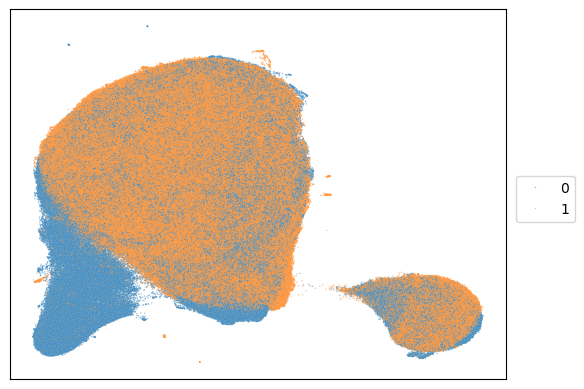

In [12]:

atom_df = df[df["labels"]!=2]
atom_df.loc[:, "new_labels"] = (atom_df["labels"] == 8).astype(int)
ax = sns.scatterplot(
    data=atom_df,
    x="x",
    y="y",
    hue="new_labels",
    alpha=0.5,
    s=1,
)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.get_legend().remove()
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(axis="both", which="both", length=0)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
plt.show()
# plt.savefig(f"{out_file_path}.png", format="png", dpi=1200)
# plt.close()